In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3808138/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Balancer"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = None


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 602 non-null    object        
 1   author             602 non-null    object        
 2   date               602 non-null    datetime64[us]
 3   start              602 non-null    datetime64[us]
 4   end                602 non-null    datetime64[us]
 5   platform_proposal  602 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 28.3+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111987 entries, 0 to 111986
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        111987 non-null  object        
 1   proposal  111987 non-null  object        
 2   voter     111987 non-null  object        
 3   date      111987 non-null  datetime64[us]
dtypes: datetime64[us](1), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111987 entries, 0 to 111986
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userID     111987 non-null  object        
 1   itemID     111987 non-null  object        
 2   timestamp  111987 non-null  datetime64[us]
 3   rating     111987 non-null  int64         
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 3.4+ MB
None


## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Balancer/baseline/folds-info_3d_normalize.parquet
fold
2023-06-18    109536
2023-06-21    109694
2023-06-24    109947
2023-06-27    110232
2023-06-30    110306
2023-07-03    110760
2023-07-06    110811
2023-07-09    111074
2023-07-12    111158
2023-07-15    111479
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W24,13,696,79,53.54,8.81,145,31,11.15,4.68
2023-W25,0,0,0,nan,nan,0,0,nan,nan
2023-W25,7,253,45,36.14,5.62,278,58,39.71,4.79
2023-W26,0,0,0,nan,nan,0,0,nan,nan
2023-W26,7,74,11,10.57,6.73,481,103,68.71,4.67
2023-W27,7,528,111,75.43,4.76,51,11,7.29,4.64
2023-W27,0,0,0,nan,nan,0,0,nan,nan
2023-W27,3,263,108,87.67,2.44,84,36,28.00,2.33
2023-W28,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W24 & 13 & 696 & 79 & 53.54 & 8.81 & 145 & 31 & 11.15 & 4.68 \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W25 & 7 & 253 & 45 & 36.14 & 5.62 & 278 & 58 & 39.71 & 4.79 \\
2023-W26 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 7 & 74 & 11 & 10.57 & 6.73 & 481 & 103 & 68.71 & 4.67 \\
2023-W27 & 7 & 528 & 111 & 75.43 & 4.76 & 51 & 11 & 7.29 & 4.64 \\
2023-W27 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W27 & 3 & 263 & 108 & 87.67 & 2.44 & 84 & 36 & 28.00 & 2.33 \\
2023-W28 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W28 & 13 & 321 & 45 & 24.69 & 7.13 & 504 & 79 & 38.77 & 6.38 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/365 [00:00<?, ?it/s]

Warning, empty test fold 0 (2020-07-18 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2020-07-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2020-07-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2020-07-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2020-07-30 00:00:00), all ok since 1 folds ago
Warning, test fold 5 (2020-08-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 6 (2020-08-05 00:00:00), all ok since 2 folds ago
Warning, empty test fold 7 (2020-08-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2020-08-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2020-08-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2020-08-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2020-08-20 00:00:00), all ok since 1 folds ago


Warning, test fold 12 (2020-08-23 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 13 (2020-08-26 00:00:00), all ok since 2 folds ago
Warning, empty test fold 14 (2020-08-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 15 (2020-09-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 16 (2020-09-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 17 (2020-09-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 18 (2020-09-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 19 (2020-09-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 20 (2020-09-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 21 (2020-09-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 22 (2020-09-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 23 (2020-09-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 24 (2020-09-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 25 (2020-10-01 00:00:00), all ok since 1 folds ago
Warning, test fold 26 (2020-10-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 27 (2020-10-07 00:00:00), all ok since 2 folds ago
Warning, test fold 28 (2020-10-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 29 (2020-10-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 30 (2020-10-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 31 (2020-10-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 32 (2020-10-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 33 (2020-10-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 34 (2020-10-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 35 (2020-10-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 36 (2020-11-03 00:00:00), all ok since 1 folds ago


Warning, test fold 37 (2020-11-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 38 (2020-11-09 00:00:00), all ok since 2 folds ago
Warning, empty test fold 39 (2020-11-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 40 (2020-11-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 41 (2020-11-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 42 (2020-11-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 43 (2020-11-24 00:00:00), all ok since 1 folds ago


Warning, test fold 44 (2020-11-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 45 (2020-11-30 00:00:00), all ok since 2 folds ago
Warning, empty test fold 46 (2020-12-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 47 (2020-12-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 48 (2020-12-09 00:00:00), all ok since 1 folds ago


Warning, test fold 49 (2020-12-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 50 (2020-12-15 00:00:00), all ok since 2 folds ago
Warning, test fold 51 (2020-12-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 52 (2020-12-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 53 (2020-12-24 00:00:00), all ok since 3 folds ago
Warning, empty test fold 54 (2020-12-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 55 (2020-12-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 56 (2021-01-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 57 (2021-01-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 58 (2021-01-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 59 (2021-01-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 60 (2021-01-14 00:00:00), all ok since 1 folds ago


Warning, test fold 61 (2021-01-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 62 (2021-01-20 00:00:00), all ok since 2 folds ago
Warning, test fold 63 (2021-01-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 64 (2021-01-26 00:00:00), all ok since 2 folds ago
Warning, empty test fold 65 (2021-01-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 66 (2021-02-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 67 (2021-02-04 00:00:00), all ok since 1 folds ago


Warning, test fold 68 (2021-02-07 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 69 (2021-02-10 00:00:00), all ok since 2 folds ago
Warning, test fold 70 (2021-02-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 71 (2021-02-16 00:00:00), all ok since 2 folds ago
Warning, empty test fold 72 (2021-02-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 73 (2021-02-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 74 (2021-02-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 75 (2021-02-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 76 (2021-03-03 00:00:00), all ok since 1 folds ago


Warning, test fold 77 (2021-03-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 78 (2021-03-09 00:00:00), all ok since 2 folds ago
Warning, empty test fold 79 (2021-03-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 80 (2021-03-15 00:00:00), all ok since 1 folds ago
Warning, empty test fold 81 (2021-03-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 82 (2021-03-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 83 (2021-03-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 84 (2021-03-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 85 (2021-03-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 86 (2021-04-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 87 (2021-04-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 88 (2021-04-08 00:00:00), all ok since 1 folds ago
Warning, test fold 89 (2021-04-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 90 (2021-04-14 00:00:00), all ok since 2 folds ago
Warning, test fold 91 (2021-04-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 92 (2021-04-20 00:00:00), all ok since 2 folds ago
Warning, empty test fold 93 (2021-04-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 94 (2021-04-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 95 (2021-04-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 96 (2021-05-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 97 (2021-05-05 00:00:00), all ok since 1 folds ago


Warning, test fold 98 (2021-05-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 99 (2021-05-11 00:00:00), all ok since 2 folds ago
Warning, test fold 100 (2021-05-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 101 (2021-05-17 00:00:00), all ok since 2 folds ago
Warning, empty test fold 102 (2021-05-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 103 (2021-05-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 104 (2021-05-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 105 (2021-05-29 00:00:00), all ok since 1 folds ago
Warning, empty test fold 106 (2021-06-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 107 (2021-06-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 108 (2021-06-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 109 (2021-06-10 00:00:00), all ok since 1 folds ago
Warning, test fold 110 (2021-06-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 111 (2021-06-16 00:00:00), all ok since 2 folds ago
Warning, test fold 112 (2021-06-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 113 (2021-06-22 00:00:00), all ok since 2 folds ago
Warning, empty test fold 114 (2021-06-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 115 (2021-06-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 116 (2021-07-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 117 (2021-07-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 118 (2021-07-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 119 (2021-07-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 120 (2021-07-13 00:00:00), all ok since 1 folds ago


Warning, empty test fold 121 (2021-07-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 122 (2021-07-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 123 (2021-07-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 124 (2021-07-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 125 (2021-07-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 126 (2021-07-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 127 (2021-08-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 128 (2021-08-06 00:00:00), all ok since 1 folds ago


Warning, test fold 129 (2021-08-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 130 (2021-08-12 00:00:00), all ok since 2 folds ago
Warning, test fold 131 (2021-08-15 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 132 (2021-08-18 00:00:00), all ok since 2 folds ago
Warning, test fold 133 (2021-08-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 134 (2021-08-24 00:00:00), all ok since 2 folds ago
Warning, empty test fold 135 (2021-08-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 136 (2021-08-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 137 (2021-09-02 00:00:00), all ok since 1 folds ago


Warning, test fold 138 (2021-09-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 139 (2021-09-08 00:00:00), all ok since 2 folds ago
Warning, empty test fold 140 (2021-09-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 141 (2021-09-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 142 (2021-09-17 00:00:00), all ok since 1 folds ago


Warning, test fold 143 (2021-09-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 144 (2021-09-23 00:00:00), all ok since 2 folds ago
Warning, empty test fold 145 (2021-09-26 00:00:00), all ok since 1 folds ago


Warning, test fold 146 (2021-09-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 147 (2021-10-02 00:00:00), all ok since 2 folds ago
Warning, empty test fold 148 (2021-10-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 149 (2021-10-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 150 (2021-10-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 151 (2021-10-14 00:00:00), all ok since 1 folds ago
Warning, test fold 152 (2021-10-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 153 (2021-10-20 00:00:00), all ok since 2 folds ago
Warning, empty test fold 154 (2021-10-23 00:00:00), all ok since 1 folds ago


Warning, test fold 155 (2021-10-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 156 (2021-10-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 157 (2021-11-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 158 (2021-11-04 00:00:00), all ok since 4 folds ago
Warning, test fold 159 (2021-11-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 160 (2021-11-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 161 (2021-11-13 00:00:00), all ok since 3 folds ago
Warning, empty test fold 162 (2021-11-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 163 (2021-11-19 00:00:00), all ok since 1 folds ago
Warning, test fold 164 (2021-11-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 165 (2021-11-25 00:00:00), all ok since 2 folds ago
Warning, empty test fold 166 (2021-11-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 167 (2021-12-01 00:00:00), all ok since 1 folds ago
Warning, test fold 168 (2021-12-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 169 (2021-12-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 170 (2021-12-10 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 171 (2021-12-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 172 (2021-12-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 173 (2021-12-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 174 (2021-12-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 175 (2021-12-25 00:00:00), all ok since 8 folds ago
Warning, empty test fold 176 (2021-12-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 177 (2021-12-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 178 (2022-01-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 179 (2022-01-06 00:00:00), all ok since 1 folds ago
Warning, empty test fold 180 (2022-01-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 181 (2022-01-12 00:00:00), all ok since 1 folds ago
Warning, test fold 182 (2022-01-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 183 (2022-01-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 184 (2022-01-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 185 (2022-01-24 00:00:00), all ok since 1 folds ago
Warning, test fold 186 (2022-01-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 187 (2022-01-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 188 (2022-02-02 00:00:00), all ok since 3 folds ago
Warning, empty test fold 189 (2022-02-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 190 (2022-02-08 00:00:00), all ok since 1 folds ago
Warning, test fold 191 (2022-02-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 192 (2022-02-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 193 (2022-02-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 194 (2022-02-20 00:00:00), all ok since 4 folds ago
Warning, empty test fold 195 (2022-02-23 00:00:00), all ok since 1 folds ago


Warning, test fold 196 (2022-02-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 197 (2022-03-01 00:00:00), all ok since 2 folds ago
Warning, empty test fold 198 (2022-03-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 199 (2022-03-07 00:00:00), all ok since 1 folds ago
Warning, test fold 200 (2022-03-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 201 (2022-03-13 00:00:00), all ok since 2 folds ago
Warning, empty test fold 202 (2022-03-16 00:00:00), all ok since 1 folds ago


Warning, test fold 203 (2022-03-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 204 (2022-03-22 00:00:00), all ok since 2 folds ago
Warning, test fold 205 (2022-03-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 206 (2022-03-28 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 207 (2022-03-31 00:00:00), all ok since 3 folds ago
Warning, empty test fold 208 (2022-04-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 209 (2022-04-06 00:00:00), all ok since 1 folds ago
Warning, test fold 210 (2022-04-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 211 (2022-04-12 00:00:00), all ok since 2 folds ago
Warning, test fold 212 (2022-04-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 213 (2022-04-18 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 214 (2022-04-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 215 (2022-04-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 216 (2022-04-27 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 217 (2022-04-30 00:00:00), all ok since 6 folds ago
Warning, empty test fold 218 (2022-05-03 00:00:00), all ok since 1 folds ago


Warning, test fold 220 (2022-05-09 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 221 (2022-05-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 223 (2022-05-18 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 224 (2022-05-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 225 (2022-05-24 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 226 (2022-05-27 00:00:00), all ok since 8 folds ago
Warning, test fold 227 (2022-05-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 228 (2022-06-02 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 229 (2022-06-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 230 (2022-06-08 00:00:00), all ok since 4 folds ago


Warning, test fold 232 (2022-06-14 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, empty test fold 233 (2022-06-17 00:00:00), all ok since 3 folds ago


Warning, empty test fold 235 (2022-06-23 00:00:00), all ok since 2 folds ago


Warning, empty test fold 237 (2022-06-29 00:00:00), all ok since 2 folds ago


Warning, test fold 239 (2022-07-05 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 240 (2022-07-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 241 (2022-07-11 00:00:00), all ok since 4 folds ago
Warning, empty test fold 242 (2022-07-14 00:00:00), all ok since 1 folds ago


Warning, test fold 243 (2022-07-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 244 (2022-07-20 00:00:00), all ok since 2 folds ago


Warning, empty test fold 246 (2022-07-26 00:00:00), all ok since 2 folds ago
Warning, test fold 247 (2022-07-29 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 248 (2022-08-01 00:00:00), all ok since 2 folds ago
Warning, empty test fold 249 (2022-08-04 00:00:00), all ok since 1 folds ago


Warning, test fold 250 (2022-08-07 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 251 (2022-08-10 00:00:00), all ok since 2 folds ago
Warning, test fold 252 (2022-08-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 253 (2022-08-16 00:00:00), all ok since 2 folds ago


Warning, empty test fold 255 (2022-08-22 00:00:00), all ok since 2 folds ago
Warning, empty test fold 256 (2022-08-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 258 (2022-08-31 00:00:00), all ok since 2 folds ago
Warning, test fold 259 (2022-09-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 260 (2022-09-06 00:00:00), all ok since 2 folds ago
Warning, empty test fold 261 (2022-09-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 263 (2022-09-15 00:00:00), all ok since 2 folds ago
Warning, test fold 264 (2022-09-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 265 (2022-09-21 00:00:00), all ok since 2 folds ago


Warning, empty test fold 267 (2022-09-27 00:00:00), all ok since 2 folds ago


Warning, empty test fold 269 (2022-10-03 00:00:00), all ok since 2 folds ago
Warning, empty test fold 270 (2022-10-06 00:00:00), all ok since 1 folds ago


Warning, test fold 271 (2022-10-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 272 (2022-10-12 00:00:00), all ok since 2 folds ago


Warning, empty test fold 274 (2022-10-18 00:00:00), all ok since 2 folds ago


Warning, empty test fold 276 (2022-10-24 00:00:00), all ok since 2 folds ago
Warning, empty test fold 277 (2022-10-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 279 (2022-11-02 00:00:00), all ok since 2 folds ago


Warning, empty test fold 281 (2022-11-08 00:00:00), all ok since 2 folds ago
Warning, test fold 282 (2022-11-11 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 283 (2022-11-14 00:00:00), all ok since 2 folds ago
Warning, empty test fold 284 (2022-11-17 00:00:00), all ok since 1 folds ago


Warning, test fold 285 (2022-11-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 286 (2022-11-23 00:00:00), all ok since 2 folds ago
Warning, test fold 287 (2022-11-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 288 (2022-11-29 00:00:00), all ok since 2 folds ago


Warning, empty test fold 291 (2022-12-08 00:00:00), all ok since 3 folds ago


Warning, empty test fold 293 (2022-12-14 00:00:00), all ok since 2 folds ago


Warning, empty test fold 295 (2022-12-20 00:00:00), all ok since 2 folds ago
Warning, test fold 296 (2022-12-23 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 297 (2022-12-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 298 (2022-12-29 00:00:00), all ok since 3 folds ago
Warning, empty test fold 299 (2023-01-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 300 (2023-01-04 00:00:00), all ok since 1 folds ago
Warning, test fold 301 (2023-01-07 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 302 (2023-01-10 00:00:00), all ok since 2 folds ago


Warning, empty test fold 305 (2023-01-19 00:00:00), all ok since 3 folds ago
Warning, test fold 306 (2023-01-22 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 307 (2023-01-25 00:00:00), all ok since 2 folds ago
Warning, test fold 308 (2023-01-28 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 309 (2023-01-31 00:00:00), all ok since 2 folds ago
Warning, test fold 310 (2023-02-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 311 (2023-02-06 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 312 (2023-02-09 00:00:00), all ok since 3 folds ago


Warning, empty test fold 314 (2023-02-15 00:00:00), all ok since 2 folds ago


Warning, empty test fold 316 (2023-02-21 00:00:00), all ok since 2 folds ago


Warning, empty test fold 319 (2023-03-02 00:00:00), all ok since 3 folds ago
Warning, test fold 320 (2023-03-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 321 (2023-03-08 00:00:00), all ok since 2 folds ago
Warning, test fold 322 (2023-03-11 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 323 (2023-03-14 00:00:00), all ok since 2 folds ago


Warning, empty test fold 326 (2023-03-23 00:00:00), all ok since 3 folds ago


Warning, empty test fold 328 (2023-03-29 00:00:00), all ok since 2 folds ago


Warning, empty test fold 330 (2023-04-04 00:00:00), all ok since 2 folds ago


Warning, empty test fold 333 (2023-04-13 00:00:00), all ok since 3 folds ago


Warning, empty test fold 335 (2023-04-19 00:00:00), all ok since 2 folds ago


Warning, empty test fold 337 (2023-04-25 00:00:00), all ok since 2 folds ago


Warning, empty test fold 340 (2023-05-04 00:00:00), all ok since 3 folds ago


Warning, empty test fold 342 (2023-05-10 00:00:00), all ok since 2 folds ago


Warning, empty test fold 344 (2023-05-16 00:00:00), all ok since 2 folds ago


Warning, empty test fold 347 (2023-05-25 00:00:00), all ok since 3 folds ago


Warning, empty test fold 349 (2023-05-31 00:00:00), all ok since 2 folds ago


Warning, empty test fold 351 (2023-06-06 00:00:00), all ok since 2 folds ago


Warning, empty test fold 354 (2023-06-15 00:00:00), all ok since 3 folds ago


Warning, empty test fold 356 (2023-06-21 00:00:00), all ok since 2 folds ago


Warning, empty test fold 358 (2023-06-27 00:00:00), all ok since 2 folds ago


Warning, empty test fold 361 (2023-07-06 00:00:00), all ok since 3 folds ago
Warning, test fold 362 (2023-07-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 363 (2023-07-12 00:00:00), all ok since 2 folds ago


Max ok in a row: (8, Timestamp('2021-12-25 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Balancer/baseline/openpop_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.331023,0.224094,0.175972,0.109425,0.076234,0.011435,0.331023,0.342654,0.348528,0.353114,...,0.370953,0.375342,0.375342,0.215246,0.300771,0.333620,0.355935,0.359680,0.359680,0.099589
std,0.437184,0.316611,0.269323,0.186204,0.135188,0.020278,0.437184,0.448297,0.454077,0.458507,...,0.479793,0.484876,0.484876,0.339134,0.414360,0.442580,0.462070,0.466013,0.466013,0.046032
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068228
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069219
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070409
75%,0.863636,0.425641,0.294737,0.147368,0.098246,0.014737,0.863636,0.891551,0.912730,0.924279,...,1.000000,1.000000,1.000000,0.339258,0.652361,0.921875,0.951106,0.952381,0.952381,0.129006
max,1.000000,1.000000,1.000000,0.815858,0.696014,0.104402,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.451910


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Balancer/baseline/perfect_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.375342,0.239467,0.182444,0.110073,0.076234,0.011435,0.375342,0.375342,0.375342,0.375342,...,0.371981,0.375342,0.375342,0.233358,0.321323,0.352152,0.371981,0.375342,0.375342,0.106308
std,0.484876,0.340728,0.281428,0.188177,0.135188,0.020278,0.484876,0.484876,0.484876,0.484876,...,0.480881,0.484876,0.484876,0.348443,0.430091,0.460424,0.480881,0.484876,0.484876,0.052603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072037
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073004
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074010
75%,1.000000,0.491228,0.294737,0.147368,0.098246,0.014737,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.415444,0.785294,1.000000,1.000000,1.000000,1.000000,0.134189
max,1.000000,1.000000,1.000000,0.845652,0.696014,0.104402,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.377320


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,0.0,0.0
mean,2022-01-14 23:59:59.999999744,0.331023,0.224094,0.175972,0.109425,0.076234,0.011435,0.331023,0.342654,0.348528,...,0.375342,0.215246,0.300771,0.333620,0.355935,0.359680,0.359680,0.099589,NaN,NaN
min,2020-07-18 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068228,NaN,NaN
25%,2021-04-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069219,NaN,NaN
50%,2022-01-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070409,NaN,NaN
75%,2022-10-15 00:00:00,0.863636,0.425641,0.294737,0.147368,0.098246,0.014737,0.863636,0.891551,0.912730,...,1.000000,0.339258,0.652361,0.921875,0.951106,0.952381,0.952381,0.129006,NaN,NaN
max,2023-07-15 00:00:00,1.000000,1.000000,1.000000,0.815858,0.696014,0.104402,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.451910,NaN,NaN
std,NaN,0.437184,0.316611,0.269323,0.186204,0.135188,0.020278,0.437184,0.448297,0.454077,...,0.484876,0.339134,0.414360,0.442580,0.462070,0.466013,0.466013,0.046032,NaN,NaN


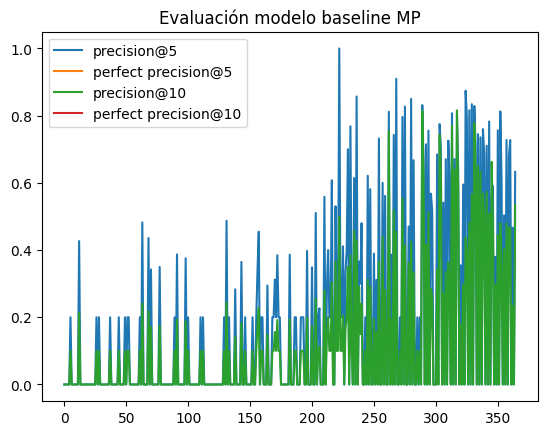

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-07-01 12:00:00,0.458121,0.412547,0.373922,0.258067,0.183266,0.027490,0.458121,0.481018,0.506013,...,0.600000,0.196720,0.358312,0.452456,0.541837,0.555338,0.555338,0.111291,NaN,NaN
min,2023-06-18 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068775,NaN,NaN
25%,2023-06-24 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069727,NaN,NaN
50%,2023-07-01 12:00:00,0.646257,0.592351,0.484946,0.318280,0.232323,0.034848,0.646257,0.676044,0.748297,...,1.000000,0.225485,0.489456,0.608729,0.786397,0.853899,0.853899,0.127372,NaN,NaN
75%,2023-07-08 06:00:00,0.760932,0.716167,0.669393,0.466152,0.311703,0.046755,0.760932,0.810086,0.863275,...,1.000000,0.327093,0.528918,0.765849,0.926174,0.926174,0.926174,0.139446,NaN,NaN
max,2023-07-15 00:00:00,0.944444,0.777778,0.727586,0.534177,0.425316,0.063797,0.944444,0.972222,0.972222,...,1.000000,0.519608,1.000000,1.000000,1.000000,1.000000,1.000000,0.154081,NaN,NaN
std,NaN,0.404094,0.362384,0.332706,0.235507,0.170304,0.025546,0.404094,0.422851,0.440373,...,0.516398,0.188122,0.342134,0.404167,0.472011,0.480658,0.480658,0.037088,NaN,NaN
